# Data Exploring & Cleaning

Today we will focus on taking a first look at some data sets and cleaning the data.

## Setting up Kaggle

First off Colaboratory users will need to run a couple of cells to get set up to aquire Kaggle data.  The cells below are currently Markdown cells.  Change these cells to Code cells and run them if you are using Colaboratory. (Tools --> Command palette --> Change to Code Cell)

In [ ]:
### Run this cell only if using Colaboratory to install the Kaggle API
!pip install kaggle

### Run this cell only if using Colaboratory to set up the Kaggle API

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

## Cleaning and Munging a Simple Data Frame

Before working with a large data set, let us first practice with a small amount of data in a simple data frame.  This example comes from [here](https://github.com/ajcr/100-pandas-puzzles/blob/master/100-pandas-puzzles-with-solutions.ipynb). The data consists of some made-up flight information.

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'From_To': ['LoNDon_paris', 'MAdrid_miLAN', 'londON_StockhOlm', 
                               'Budapest_PaRis', 'Brussels_londOn'],
              'FlightNumber': [10045, np.nan, 10065, np.nan, 10085],
              'RecentDelays': [[23, 47], [], [24, 43, 87], [13], [67, 32]],
                   'Airline': ['KLM(!)', '<Air France> (12)', '(British Airways. )', 
                               '12. Air France', '"Swiss Air"']})
df

,Airline,FlightNumber,From_To,RecentDelays
0,KLM(!),10045.0,LoNDon_paris,"[23, 47]"
1,<Air France> (12),NaN,MAdrid_miLAN,[]
2,(British Airways. ),10065.0,londON_StockhOlm,"[24, 43, 87]"
3,12. Air France,NaN,Budapest_PaRis,[13]
4,"""Swiss Air""",10085.0,Brussels_londOn,"[67, 32]"


Some values in the the FlightNumber column are missing. These numbers are meant to increase by 10 with each row so 10055 and 10075 need to be put in place. Fill in these missing numbers and make the column an integer column (instead of a float column). The pandas `interpolate` function fills in NaNs with interpolated values and is described [here](http://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.DataFrame.interpolate.html).

In [ ]:
df['FlightNumber'] = df['FlightNumber'].interpolate().astype(int)
df['FlightNumber']

0    10045
1    10055
2    10065
3    10075
4    10085
Name: FlightNumber, dtype: int64

The From_To column would be better as two separate columns! Split each string on the underscore delimiter _ to give a new temporary DataFrame with the correct values. Assign the correct column names to this temporary DataFrame.

In [ ]:
temp = df.From_To.str.split('_', expand=True)
temp.columns = ['From', 'To']
temp

,From,To
0,LoNDon,paris
1,MAdrid,miLAN
2,londON,StockhOlm
3,Budapest,PaRis
4,Brussels,londOn


Notice how the capitalisation of the city names is all mixed up in this temporary DataFrame. Standardise the strings so that only the first letter is uppercase (e.g. "LoNDon" should become "London".)  The string method `capitalize()` does just that.

In [ ]:
temp['From'] = temp['From'].str.capitalize()
temp['To'] = temp['To'].str.capitalize()
temp

,From,To
0,London,Paris
1,Madrid,Milan
2,London,Stockholm
3,Budapest,Paris
4,Brussels,London


Delete the From_To column from df and attach the temporary DataFrame.

In [ ]:
df = df.drop('From_To', axis=1)
df = df.join(temp)
df

,Airline,FlightNumber,RecentDelays,From,To
0,KLM(!),10045,"[23, 47]",London,Paris
1,<Air France> (12),10055,[],Madrid,Milan
2,(British Airways. ),10065,"[24, 43, 87]",London,Stockholm
3,12. Air France,10075,[13],Budapest,Paris
4,"""Swiss Air""",10085,"[67, 32]",Brussels,London


In the Airline column, you can see some extra puctuation and symbols have appeared around the airline names. Pull out just the airline name. E.g. '(British Airways. )' should become 'British Airways'.

In [ ]:
df['Airline'] = df['Airline'].str.extract('([a-zA-Z\s]+)', expand=False).str.strip()
# note: using .strip() gets rid of any leading/trailing spaces
df.Airline

0                KLM
1         Air France
2    British Airways
3         Air France
4          Swiss Air
Name: Airline, dtype: object

In the RecentDelays column, the values have been entered into the DataFrame as a list. We would like each first value in its own column, each second value in its own column, and so on. If there isn't an Nth value, the value should be NaN.

Expand the Series of lists into a DataFrame named delays, rename the columns delay_1, delay_2, etc. and replace the unwanted RecentDelays column in df with delays.

In [ ]:
# there are several ways to do this, but the following approach is possibly the simplest

delays = df['RecentDelays'].apply(pd.Series)

delays.columns = ['delay_{}'.format(n) for n in range(1, len(delays.columns)+1)]

df = df.drop('RecentDelays', axis=1).join(delays)

The DataFrame should look much better now.

In [ ]:
df

,Airline,FlightNumber,From,To,delay_1,delay_2,delay_3
0,KLM,10045,London,Paris,23.0,47.0,NaN
1,Air France,10055,Madrid,Milan,NaN,NaN,NaN
2,British Airways,10065,London,Stockholm,24.0,43.0,87.0
3,Air France,10075,Budapest,Paris,13.0,NaN,NaN
4,Swiss Air,10085,Brussels,London,67.0,32.0,NaN


Finally, let's replace the NaNs in the delay columns with zeros.  Take a look at the pandas [fillna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) method for a suggestion on how to do this. Also display the modified DataFrame.

In [ ]:
# Task 1: Enter code in this cell to change the NaN delays to zeros.  Re-display the modified DataFrame.

values = {'delay_1': 0, 'delay_2': 0, 'delay_3': 0}
df.fillna(value=values)

,Airline,FlightNumber,From,To,delay_1,delay_2,delay_3
0,KLM,10045,London,Paris,23.0,47.0,0.0
1,Air France,10055,Madrid,Milan,0.0,0.0,0.0
2,British Airways,10065,London,Stockholm,24.0,43.0,87.0
3,Air France,10075,Budapest,Paris,13.0,0.0,0.0
4,Swiss Air,10085,Brussels,London,67.0,32.0,0.0


## Building Permit Data 

Next we will practice cleaning a larger dataset from Kaggle.  This dataset is described in detail [here](https://www.kaggle.com/aparnashastry/building-permit-applications-data).  Go to that page to look at the column details as well as some summary statistics and histograms. The analysis we will perform will follow closely the one from [here](https://www.kaggle.com/chrisbow/cleaning-data-with-python-challenge-day-1).

The dataset describes building permits issued for San Francisco from Jan 1, 2013 to Feb 25th 2018.  First, we will download the data.

In [ ]:
from google.colab import files

uploaded = files.upload()

!unzip building-permit-applications-data

Saving building-permit-applications-data.zip to building-permit-applications-data.zip
Archive:  building-permit-applications-data.zip
  inflating: DataDictionaryBuildingPermit.xlsx  
  inflating: Building_Permits.csv    


Next, unzip the file and read the contents into a DataFrame.

In [ ]:
sfPermits = pd.read_csv("Building_Permits.csv")

NameError: ignored

Next, let us take a first look at the data.  Display some randomly selected rows from our data.  We will first set the random seed so that we get the same rows picked if we re-run the notebook.

In [ ]:
np.random.seed(0)
sfPermits.sample(5)

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
40553,201403039652,8,otc alterations permit,03/03/2014,3732,008,400,NaN,Clementina,St,...,NaN,NaN,1.0,constr type 1,NaN,6.0,South of Market,94103.0,"(37.780460571778164, -122.40450626524974)",1334094491645
169731,201510159735,3,additions alterations or repairs,10/15/2015,2609,028,79,NaN,Buena Vista,Tr,...,5.0,wood frame (5),5.0,wood frame (5),NaN,8.0,Castro/Upper Market,94117.0,"(37.76757916496494, -122.43793170417105)",1399356139170
19180,M409787,8,otc alterations permit,07/22/2013,4624,031,178,NaN,West Point,Rd,...,NaN,NaN,NaN,NaN,NaN,10.0,Bayview Hunters Point,94124.0,"(37.73524725436046, -122.38063828309745)",1311685491725
68047,201411191888,8,otc alterations permit,11/19/2014,0039,109,294,NaN,Francisco,St,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,North Beach,94133.0,"(37.805257822817126, -122.40998545760392)",1362881288870
64238,M527228,8,otc alterations permit,10/14/2014,1251,002,707,NaN,Cole,St,...,NaN,NaN,NaN,NaN,NaN,5.0,Haight Ashbury,94117.0,"(37.76836885973765, -122.45074431487859)",135886493776


Quite a few missing values visible already, and we've only looked at five rows of the dataset, cleaning will be required...

### Find out what percent of the sf_permit dataset is missing

In [ ]:
# Calculate total number of cells in dataframe
totalCells = np.product(sfPermits.shape)

# Count number of missing values per column
missingCount = sfPermits.isnull().sum()

# Calculate total number of missing values
totalMissing = missingCount.sum()

# Calculate percentage of missing values
print("The SF Permits dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

The SF Permits dataset contains 26.26 % missing values.


Look at the columns Street Number Suffix and Zipcode from the sf_permits datasets. Both of these contain missing values. Which, if either, of these are missing because they don't exist? Which, if either, are missing because they weren't recorded?

In [ ]:
missingCount[['Street Number Suffix', 'Zipcode']]

Street Number Suffix    196684
Zipcode                   1716
dtype: int64

Looks like a lot more missing values for street number suffix than zipcode. Let's check out the percentages:

In [ ]:
print("Percent missing data in Street Number Suffix column =", (round(((missingCount['Street Number Suffix'] / sfPermits.shape[0]) * 100), 2)))
print("Percent missing data in Zipcode column =", (round(((missingCount['Zipcode'] / sfPermits.shape[0]) * 100), 2)))

Percent missing data in Street Number Suffix column = 98.89
Percent missing data in Zipcode column = 0.86


As every address has a Zipcode, it looks like the missing values for this column are due to the values not being recorded. For the Street Number Suffix column, it is likely very few properties will have a suffix to the number, I see a lot of 3s, 18s, 46s, but not nearly as many 36A or 18B, so it is likely that these are missing as they don't exist.

### Try removing all the rows from the sf_permits dataset that contain missing values. How many are left?

In [ ]:
sfPermits.dropna()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID


If we drop all rows that contain a missing value, we greatly simplify our dataset. So simple, we can go for an early lunch. Every row contains at least one missing value (well, we know from our Street Number Suffix answer above that simply eliminating those gets rid of nearly 99% of our data), so we end up with a dataframe of column headers.

### Now try removing all the columns with empty values. Now how much of your data is left?

In [ ]:
sfPermitsCleanCols = sfPermits.dropna(axis=1)
sfPermitsCleanCols.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Current Status,Current Status Date,Filed Date,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,Ellis,expired,12/21/2017,05/06/2015,1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,Geary,issued,08/03/2017,04/19/2016,1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,Pacific,withdrawn,09/26/2017,05/27/2016,1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,Pacific,complete,07/24/2017,11/07/2016,1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,Market,issued,12/01/2017,11/28/2016,144548169992


In [ ]:
print("Columns in original dataset: %d \n" % sfPermits.shape[1])
print("Columns with na's dropped: %d" % sfPermitsCleanCols.shape[1])

Columns in original dataset: 43 

Columns with na's dropped: 12


Well, that gives us a clean set of values, but we've sacrificed a lot of variables in the process...

Try replacing all the NaN's in the sf_permit data with data from the row that comes directly before it and then replace all the remaining na's with 0. Since the building permits in each row are likely unrelated to the ones before and after, this is not an awesome technique but is a simple way to fill in missing data.

In [ ]:
imputeSfPermits = sfPermits.fillna(method='ffill', axis=0).fillna("0")

imputeSfPermits.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,0,Ellis,St,...,3.0,constr type 3,0,0,0,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,0,Geary,St,...,3.0,constr type 3,0,0,0,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,0,Pacific,Av,...,1.0,constr type 1,1,constr type 1,0,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,0,Pacific,Av,...,5.0,wood frame (5),5,wood frame (5),0,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,0,Market,St,...,3.0,constr type 3,5,wood frame (5),0,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


### Calculate the average GPS coordinates for San Francisco building permits

The Location column holds two values per building permit that look like (37.785719256680785, -122.40852313194863).  The first number is the GPS latitude and the second the GPS longitude.  Replace the Location column with two columns, one named GPS Lat and the other names GPS Lon that separately hold the latitude and longitude data. There are multiple methods for doing this, one uses `.str.split`, `.str.replace`, and `.astype('float')`.

In [ ]:
# Task 2: Enter code in this cell to replace the Location column of imputeSFPermits with two columns
# that hold the GPS latitude and longitude, respectively.

temp = imputeSfPermits.Location.str.split(' ', expand=True)
temp.columns = ['Latitude', 'Longtitude']
temp.head()


,Latitude,Longtitude
0,"(37.785719256680785,",-122.40852313194863)
1,"(37.78733980600732,",-122.41063199757738)
2,"(37.7946573324287,",-122.42232562979227)
3,"(37.79595867909168,",-122.41557405519474)
4,"(37.78315261897309,",-122.40950883997789)


Finally, calculate the average latitude and average longitude of the San Francisco Permit locations

In [ ]:
# Task 3: Enter code to compute the average lat and lon values.

lat = imputeSfPermits['Latitude'].mean()
lon = imputeSfPermits['Longtitude'].mean()


NameError: name 'imputeSfPermits' is not defined

## IMDB Movie Data

Next we will be inspecting and cleaning a dataset from Kaggle that consists of data scraped from the IMDB website.  The Kaggle site for the data is [here](https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset) and we will be following an analysis recommended by [this site](http://www.developintelligence.com/blog/2017/08/data-cleaning-pandas-python/).

First, we will download and unzip the data.

In [ ]:
! kaggle datasets download -d carolzhangdc/imdb-5000-movie-dataset

In [ ]:
! unzip imdb-5000-movie-dataset.zip

Archive:  imdb-5000-movie-dataset.zip
  inflating: movie_metadata.csv      


Then read the data into a DataFrame

In [ ]:
imdb_df = pd.read_csv('movie_metadata.csv')
imdb_df.head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


We can see that there are some missing values and that some movies have very incomplete information (look at row 4, for example).  We can eliminate these rows from our set. With the `dropna` method used below, axis = 0 means go by row (axis = 1 means go by column) and thresh = 10 means drop any rows with fewer than 10 non-NaN values.

In [ ]:
numrows_before, _ = imdb_df.shape
imdb_df = imdb_df.dropna(axis=0, thresh=20) 
numrows_after, _ = imdb_df.shape
numrows_removed = numrows_before - numrows_after

print('{} rows removed'.format(numrows_removed))

5 rows removed


In [ ]:
imdb_df.head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000
10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,Action|Adventure|Sci-Fi,...,3018.0,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000


Of course, we could also drop rows with any missing information via `.dropna()` but we would likely lose a lot of our dataset.  If we want to drop rows that contain only missing information values, we can use `.dropna(how='all')` but it is unlikely that we would have rows with absolutely no information.

Let us next investigate which are the most problematic columns.

In [ ]:
missingCount = imdb_df.isnull().sum()
missingCount

color                         16
director_name                100
num_critic_for_reviews        46
duration                      14
director_facebook_likes      100
actor_3_facebook_likes        18
actor_2_name                   9
actor_1_facebook_likes         6
gross                        877
genres                         0
actor_1_name                   6
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  18
facenumber_in_poster          13
plot_keywords                150
movie_imdb_link                0
num_user_for_reviews          17
language                       9
country                        3
content_rating               296
budget                       487
title_year                   102
actor_2_facebook_likes         9
imdb_score                     0
aspect_ratio                 322
movie_facebook_likes           0
dtype: int64

Some columns contain strings.  It would be appropriate to replace missing string values with an empty string

In [ ]:
imdb_df['color'] = imdb_df['color'].fillna('')
missingCount = imdb_df.isnull().sum()
missingCount

color                          0
director_name                100
num_critic_for_reviews        46
duration                      14
director_facebook_likes      100
actor_3_facebook_likes        18
actor_2_name                   9
actor_1_facebook_likes         6
gross                        877
genres                         0
actor_1_name                   6
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  18
facenumber_in_poster          13
plot_keywords                150
movie_imdb_link                0
num_user_for_reviews          17
language                       9
country                        3
content_rating               296
budget                       487
title_year                   102
actor_2_facebook_likes         9
imdb_score                     0
aspect_ratio                 322
movie_facebook_likes           0
dtype: int64

In [ ]:
# Task 4: Enter code to replace the rest of the missing string values with empty strings

Let's say that the year that the movie came out is very important to us and we just don't care about movies where that information is not available.

In [ ]:
imdb_df = imdb_df.dropna(subset=['title_year'])

`title_year` may be a confusing column header, so we can rename it.

In [ ]:
imdb_df = imdb_df.rename(columns = {'title_year':'release_date'})
imdb_df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'release_date', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

Let's make a histogram of release dates.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121f3cd68>]],
      dtype=object)

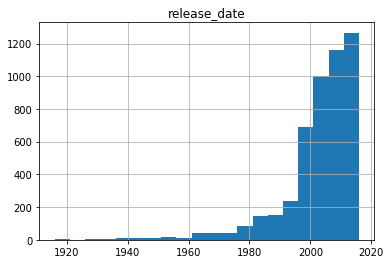

In [ ]:
%matplotlib inline

imdb_df.hist(column='release_date', bins=20)

In [ ]:
# Task 5: Calculate and output the min, max, mean, and standard deviation of the imdb_score.
# Also plot a histogram of the values stored in this column.

Looking back at what data is missing, we can see that not every movie has a duration available.  If we want to fill in these missing duration values, a crude way of doing this would be to replace the missing values with the mean movie duration.  Since most movies have durations that fall within a range of times, this would be better than simply setting the missing values to zero.

In [ ]:
imdb_df.duration = imdb_df.duration.fillna(imdb_df.duration.mean())

In [ ]:
missingCount = imdb_df.isnull().sum()
missingCount

color                          0
director_name                  0
num_critic_for_reviews        40
duration                       0
director_facebook_likes        0
actor_3_facebook_likes        17
actor_2_name                   9
actor_1_facebook_likes         6
gross                        778
genres                         0
actor_1_name                   6
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  17
facenumber_in_poster          13
plot_keywords                140
movie_imdb_link                0
num_user_for_reviews          14
language                       9
country                        1
content_rating               260
budget                       392
release_date                   0
actor_2_facebook_likes         9
imdb_score                     0
aspect_ratio                 306
movie_facebook_likes           0
dtype: int64

In [ ]:
# Task 6: Replace the missing values in the remaining columns. 
# Re-calculate missingCount to show that you have successfully replaced them.